In [ ]:
"""
Improved FraudDiffuse Model – End-to-End using ONLY StandardScaler
Based strictly on Data_Preprocessing.ipynb (which applied StandardScaler to all numeric features).
Improvements:
  • We compute the observed min/max values (in the standardized space) for engineered features.
  • During training we add an extra loss to penalize denoised values for engineered features falling outside the observed range.
  • During synthesis we also clip the engineered features to that range.
"""

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True


#############################################
# Step 1: Load Preprocessed Data & Artifacts
#############################################
# Use raw strings to avoid escape-sequence issues.
X_train_df = pd.read_csv("Data/processed/X_train.csv")
y_train_df = pd.read_csv("Data/processed/y_train.csv")


X_test_df = pd.read_csv("Data/processed/X_test.csv")
y_test_df = pd.read_csv("Data/processed/y_test.csv")

scaler = joblib.load("Data/processed/standard_scaler.pkl")
cat_vocab = joblib.load("Data/processed/cat_vocab.pkl")
cat_mapping = joblib.load("Data/processed/cat_mapping.pkl")
print("Loaded StandardScaler and categorical artifacts.")

# Define feature lists exactly as used during preprocessing.
# All numeric features were standard-scaled.
numeric_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long',
                    'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']
# Categorical features (factorized)
cat_features = ['merchant', 'category', 'gender', 'street', 'city', 'state', 'zip', 'job']

# Get target values (assume first column in y_train_df is target).
y_train = y_train_df.iloc[:, 0]

# Create masks.
fraud_mask = (y_train == 1)
nonfraud_mask = (y_train == 0)

# Filter training data.
X_train_num = X_train_df[numeric_features].loc[fraud_mask].values   # Standard-scaled numeric features.
X_train_cat = X_train_df[cat_features].loc[fraud_mask].values         # Integer codes.

X_nonfraud_num = X_train_df[numeric_features].loc[nonfraud_mask].values

#############################################
# Step 1b: Compute observed range for engineered features
#############################################
# Engineered features are those extracted from datetime:
eng_features = ['trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']
# Find their indices in "numeric_features"
eng_indices = [numeric_features.index(feat) for feat in eng_features]

# Compute column-wise min and max for engineered features from the fraud training set
# (They are in standardized space.)
eng_min_np = np.min(X_train_num[:, eng_indices], axis=0)
eng_max_np = np.max(X_train_num[:, eng_indices], axis=0)
# Convert to torch tensors
eng_min = torch.tensor(eng_min_np, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")
eng_max = torch.tensor(eng_max_np, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")
print("Engineered features - observed min:", eng_min_np, "max:", eng_max_np)

#############################################
# Step 2: Create a Custom Dataset for Fraud Samples
#############################################
class SparkovFraudDataset(Dataset):
    def __init__(self, num_data, cat_data):
        self.num_data = torch.tensor(num_data, dtype=torch.float32)
        self.cat_data = torch.tensor(cat_data, dtype=torch.long)
    def __len__(self):
        return self.num_data.shape[0]
    def __getitem__(self, idx):
        return self.num_data[idx], self.cat_data[idx]

fraud_dataset = SparkovFraudDataset(X_train_num, X_train_cat)

#############################################
# Step 3: Set Device and Diffusion Hyperparameters
#############################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

T_train = 800
beta_start = 1e-4
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T_train).to(device)
alpha = 1.0 - beta
alpha_hat = torch.cumprod(alpha, dim=0)

w1 = 0.2
w2 = 0.6
lambda_eng = 0.1   # weight for engineered range loss

#############################################
# Step 4: Define the Diffusion Model
#############################################
class CombinedNoisePredictor(nn.Module):
    """
    This model follows the paper:
      - It takes in standard-scaled numeric features and factorized categorical features.
      - Categorical features are embedded and concatenated with numeric features.
      - A normalized timestep is appended.
      - The resulting vector is passed through an MLP (with LeakyReLU) to predict added noise.
    """
    def __init__(self, num_input_dim, cat_vocab_sizes, cat_embed_dim=2, hidden_dim=256):
        super(CombinedNoisePredictor, self).__init__()
        self.embeddings = nn.ModuleDict()
        for col, vocab in cat_vocab_sizes.items():
            self.embeddings[col] = nn.Embedding(vocab, cat_embed_dim)
        cat_total_dim = len(cat_vocab_sizes) * cat_embed_dim
        combined_input_dim = num_input_dim + cat_total_dim
        self.fc1 = nn.Linear(combined_input_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, combined_input_dim)
        self.activation = nn.LeakyReLU()
    def forward(self, x_num, x_cat, t):
        embeds = []
        for i, col in enumerate(self.embeddings):
            emb = self.embeddings[col](x_cat[:, i])
            embeds.append(emb)
        x_cat_emb = torch.cat(embeds, dim=1)
        x = torch.cat([x_num, x_cat_emb], dim=1)
        t_norm = t.unsqueeze(1).float() / T_train
        x_input = torch.cat([x, t_norm], dim=1)
        h = self.activation(self.fc1(x_input))
        h = self.activation(self.fc2(h))
        out = self.fc3(h)
        return out

cat_vocab_sizes = {col: cat_vocab[col] for col in cat_features}
print("Categorical vocabulary sizes:", cat_vocab_sizes)

num_input_dim = len(numeric_features)
model = CombinedNoisePredictor(num_input_dim=num_input_dim,
                               cat_vocab_sizes=cat_vocab_sizes,
                               cat_embed_dim=2,
                               hidden_dim=256).to(device)

#############################################
# Step 5: Define Loss Functions, Forward Diffusion, and Engineered Range Loss
#############################################
X_nonfraud_tensor = torch.tensor(X_nonfraud_num, dtype=torch.float32).to(device)
mu_nf = X_nonfraud_tensor.mean(dim=0, keepdim=True)
sigma_nf = X_nonfraud_tensor.std(dim=0, keepdim=True) + 1e-5

def forward_diffusion(x0, t):
    sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
    sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
    noise = torch.randn_like(x0).to(device)
    x_t = sqrt_alpha_hat_t * x0 + sqrt_one_minus_alpha_hat_t * noise
    return x_t, noise

# def compute_Lnorm(pred_noise, true_noise):
#     return F.mse_loss(pred_noise, true_noise)

def compute_feature_weighted_Lnorm(pred_noise, true_noise):
    # Feature-specific weights - higher for problematic features
    feature_weights = torch.ones(num_input_dim, device=device)
    # Indices in numeric_features for challenging features
    amt_idx = numeric_features.index('amt')
    hour_idx = numeric_features.index('trans_hour')
    month_idx = numeric_features.index('trans_month')
    dow_idx = numeric_features.index('trans_dayofweek')
    
    # Apply higher weights to challenging features
    feature_weights[amt_idx] = 2.0  # Amount needs significant improvement
    feature_weights[hour_idx] = 1.5
    feature_weights[month_idx] = 1.3
    feature_weights[dow_idx] = 1.3
    
    # Weighted MSE
    squared_diff = (pred_noise - true_noise)**2
    weighted_squared_diff = squared_diff * feature_weights.unsqueeze(0)
    return weighted_squared_diff.mean()


def compute_Lprior(pred_noise):
    z = (pred_noise - mu_nf) / sigma_nf
    z_abs = torch.abs(z)
    normal = torch.distributions.Normal(0,1)
    prob = 1 - normal.cdf(z_abs)
    L_prior = 1 - 2 * prob
    return L_prior.mean()

def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_distance = F.pairwise_distance(anchor, positive, p=2)
    neg_distance = F.pairwise_distance(anchor, negative, p=2)
    loss = F.relu(pos_distance - neg_distance + margin)
    return loss.mean()

def engineered_range_loss(x0_est_eng, eng_min, eng_max):
    # x0_est_eng is [batch, num_engineered]
    # Penalize values below eng_min or above eng_max.
    lower_penalty = F.relu(eng_min - x0_est_eng)
    upper_penalty = F.relu(x0_est_eng - eng_max)
    return torch.mean(lower_penalty + upper_penalty)

#############################################
# Step 6: Train the Diffusion Model (Fraud Samples Only)
#############################################
loader = DataLoader(fraud_dataset, batch_size=40, shuffle=True)
num_epochs = 200
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Starting training …")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in loader:
        x0_num, x0_cat = batch
        x0_num = x0_num.to(device)
        x0_cat = x0_cat.to(device)
        batch_size = x0_num.shape[0]
        
        t = torch.randint(0, T_train, (batch_size,), device=device)
        x_t_num, true_noise = forward_diffusion(x0_num, t)
        pred_noise = model(x_t_num, x0_cat, t)
        # Extract predicted noise for numeric features (first num_input_dim columns)
        pred_noise_numeric = pred_noise[:, :num_input_dim]
        
        L_norm = compute_feature_weighted_Lnorm(pred_noise_numeric, true_noise)
        L_prior = compute_Lprior(pred_noise_numeric)
        
        sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
        # One-step reverse update: estimated denoised x0.
        x0_est = (x_t_num - sqrt_one_minus_alpha_hat_t * pred_noise_numeric) / sqrt_alpha_hat_t
        
        neg_indices = torch.randint(0, X_nonfraud_tensor.shape[0], (batch_size,), device=device)
        negative_sample = X_nonfraud_tensor[neg_indices]
        L_triplet = triplet_loss(x0_est, x0_num, negative_sample)
        
        # Compute engineered range loss on engineered feature indices.
        x0_est_eng = x0_est[:, eng_indices]
        L_eng = engineered_range_loss(x0_est_eng, eng_min, eng_max)
        
        total_loss = L_norm + w1 * L_prior + w2 * L_triplet + lambda_eng * L_eng
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()
    
    avg_loss = epoch_loss / len(loader)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete. Saving model as 'fraud_diffuse_model_sparkov_improved.pth' …")
torch.save(model.state_dict(), "baseline_improved_v2_XGBOOST.pth")
print("Model saved.")

#############################################
# Step 7: Generate Synthetic Fraud Samples via Reverse Diffusion
#############################################
def generate_synthetic_fraud(model, num_samples, T_gen=T_train):
    model.eval()
    with torch.no_grad():
        cat_samples = {}
        for col in cat_vocab_sizes:
            vocab_size = cat_vocab_sizes[col]
            cat_samples[col] = torch.randint(0, vocab_size, (num_samples,), device=device, dtype=torch.long)
        x_cat = torch.stack([cat_samples[col] for col in cat_features], dim=1)
        
        X_fraud_tensor = torch.tensor(X_train_num, dtype=torch.float32).to(device)
        # noise = torch.randn(num_samples, num_input_dim).to(device)
        # x_t_num = X_fraud_tensor.mean(dim=0, keepdim=True).repeat(num_samples, 1) + \
        #           X_fraud_tensor.std(dim=0, keepdim=True).repeat(num_samples, 1) * noise
        # Use real samples as initialization base
        idx = torch.randint(0, X_fraud_tensor.shape[0], (num_samples,), device=device)
        noise = torch.randn(num_samples, num_input_dim).to(device) * 0.7  # Reduced noise scale
        x_t_num = X_fraud_tensor[idx] + X_fraud_tensor.std(dim=0, keepdim=True) * noise   
             
        for t_step in reversed(range(1, T_gen)):
            t = torch.full((num_samples,), t_step, device=device, dtype=torch.long)
            pred_noise = model(x_t_num, x_cat, t)
            pred_noise_numeric = pred_noise[:, :num_input_dim]
            beta_t = beta[t].unsqueeze(1)
            sqrt_alpha_t = torch.sqrt(alpha[t]).unsqueeze(1)
            sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
            z = torch.randn_like(x_t_num) if t_step > 1 else torch.zeros_like(x_t_num)
            x_t_num = (x_t_num - (beta_t / sqrt_one_minus_alpha_hat_t) * pred_noise_numeric) / sqrt_alpha_t \
                      + torch.sqrt(beta_t) * z
        
        # After reverse diffusion, clip engineered features to observed range.
        x_t_num_clipped = x_t_num.clone()
        x0_est_eng = x_t_num[:, eng_indices]
        x0_est_eng = torch.max(torch.min(x0_est_eng, eng_max.unsqueeze(0)), eng_min.unsqueeze(0))
        x_t_num_clipped[:, eng_indices] = x0_est_eng
        
        return x_t_num_clipped, x_cat


c:\Users\Owner\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded StandardScaler and categorical artifacts.
Engineered features - observed min: [-1.87890062 -1.67309039 -1.79624861 -1.3500817 ] max: [1.49563575 1.70671805 1.41547433 1.37969415]
Using device: cuda
Categorical vocabulary sizes: {'merchant': 693, 'category': 14, 'gender': 2, 'street': 999, 'city': 906, 'state': 51, 'zip': 985, 'job': 497}
Starting training …
Epoch [1/200], Loss: 1.1343
Epoch [10/200], Loss: 0.6373
Epoch [20/200], Loss: 0.5171
Epoch [30/200], Loss: 0.4686
Epoch [40/200], Loss: 0.4272
Epoch [50/200], Loss: 0.4054
Epoch [60/200], Loss: 0.3983
Epoch [70/200], Loss: 0.3811
Epoch [80/200], Loss: 0.3631
Epoch [90/200], Loss: 0.3532
Epoch [100/200], Loss: 0.3360
Epoch [110/200], Loss: 0.3376
Epoch [120/200], Loss: 0.3317
Epoch [130/200], Loss: 0.3238
Epoch [140/200], Loss: 0.3133
Epoch [150/200], Loss: 0.2951
Epoch [160/200], Loss: 0.2980
Epoch [170/200], Loss: 0.2858
Epoch [180/200], Loss: 0.2834
Epoch [190/200], Loss: 0.2791
Epoch [200/200], Loss: 0.2869
Training compl

Synthetic numeric samples shape (normalized): torch.Size([100000, 11])
Synthetic categorical samples shape: torch.Size([100000, 8])
Real Fraud Numeric Statistics (Original Scale):
               amt          lat         long     city_pop    merch_lat  \
count  6273.000000  6273.000000  6273.000000  6273.000000  6273.000000   
mean      5.553833    38.720264   -90.184822     8.427249    38.711246   
std       1.627878     5.105657    14.214255     2.443052     5.140968   
min       0.722706    20.027100  -165.672302     3.178054    19.161783   
25%       5.479722    34.990601   -96.790901     6.679599    35.018204   
50%       5.958528    39.455799   -87.366699     7.940228    39.451233   
75%       6.802939    42.176701   -80.057297     9.893640    42.062038   
max       7.227692    66.693298   -67.950302    14.882529    67.188110   

        merch_long          age    trans_hour    trans_day  trans_month  \
count  6273.000000  6273.000000  6.273000e+03  6273.000000  6273.000000   
mea

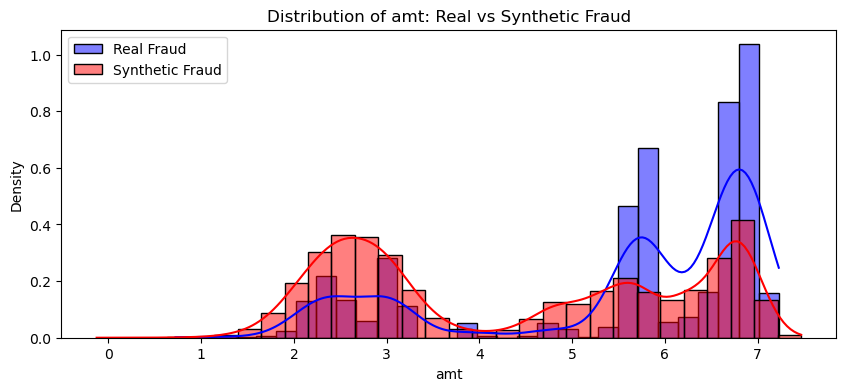

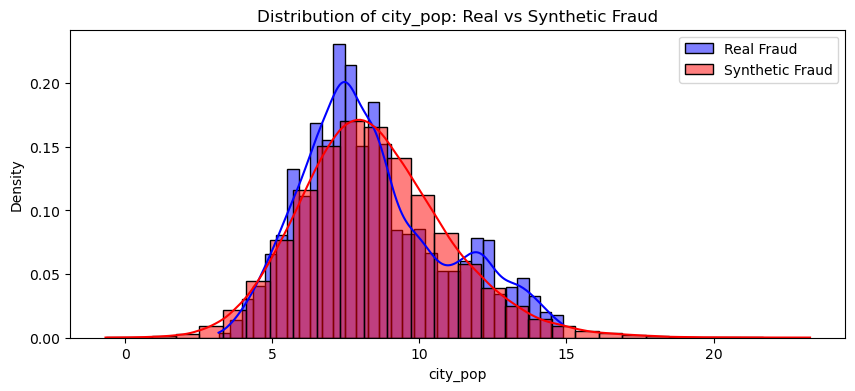

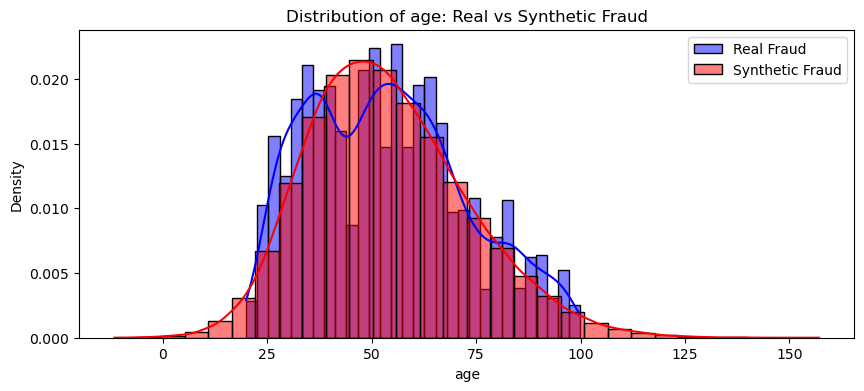

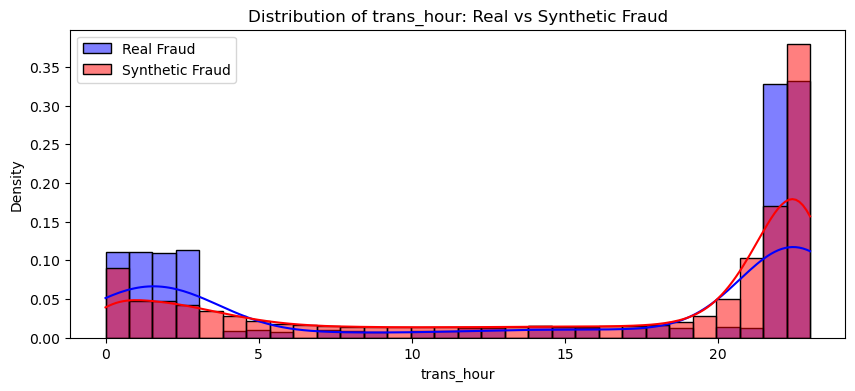

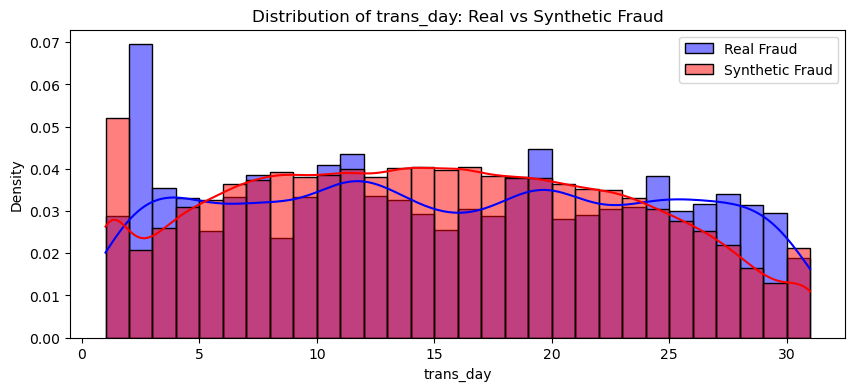

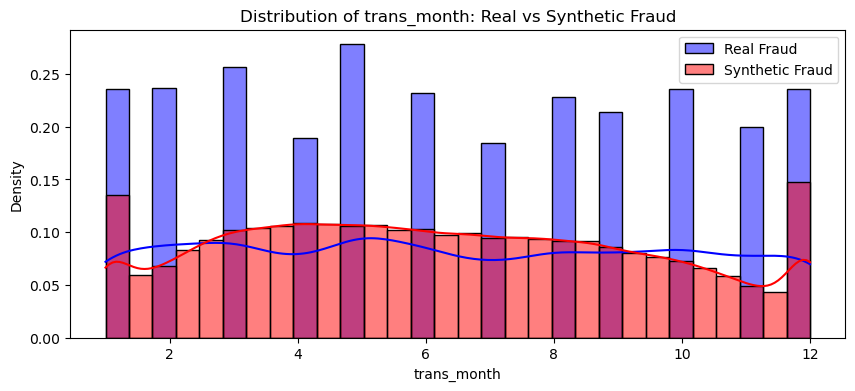

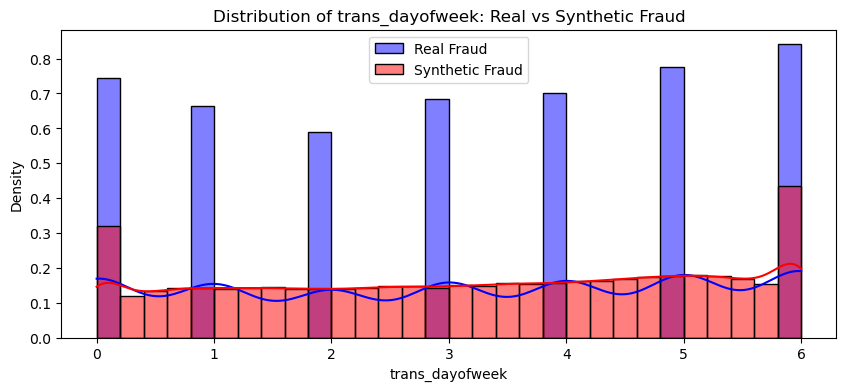

In [9]:
num_synthetic = 100000
synthetic_num_norm, synthetic_cat = generate_synthetic_fraud(model, num_synthetic)
print("Synthetic numeric samples shape (normalized):", synthetic_num_norm.shape)
print("Synthetic categorical samples shape:", synthetic_cat.shape)

#############################################
# Step 8: Inverse Transform Numeric Features to Original Scale
#############################################
synthetic_num_norm_np = synthetic_num_norm.cpu().numpy()
synthetic_num_original = scaler.inverse_transform(synthetic_num_norm_np)

numeric_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']

#############################################
# Step 9: Combine Numeric and Categorical Parts and Evaluate
#############################################
synthetic_numeric_df = pd.DataFrame(synthetic_num_original, columns=numeric_features)
synthetic_cat_df = pd.DataFrame(synthetic_cat.cpu().numpy(), columns=cat_features)
synthetic_full_df = pd.concat([synthetic_numeric_df, synthetic_cat_df], axis=1)

X_fraud_tensor = torch.tensor(X_train_num, dtype=torch.float32)
real_numeric = scaler.inverse_transform(X_fraud_tensor.cpu().numpy())
real_numeric_df = pd.DataFrame(real_numeric, columns=numeric_features)

print("Real Fraud Numeric Statistics (Original Scale):")
print(real_numeric_df.describe())
print("\nSynthetic Fraud Numeric Statistics (After Inverse Transform):")
print(synthetic_numeric_df.describe())

for col in ['amt', 'city_pop', 'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']:
    plt.figure(figsize=(10,4))
    sns.histplot(real_numeric_df[col], color='blue', label='Real Fraud', kde=True, bins=30, stat="density")
    sns.histplot(synthetic_numeric_df[col], color='red', label='Synthetic Fraud', kde=True, bins=30, stat="density")
    plt.legend()
    plt.title(f"Distribution of {col}: Real vs Synthetic Fraud")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# -------------------------------
# Load Real + Synthetic Data
# -------------------------------
X_real = X_train_df.copy()
y_real = y_train.copy()

# Assign labels (1 = fraud) to synthetic samples
y_synthetic = pd.Series([1] * len(synthetic_full_df), name="is_fraud")

# Concatenate real and synthetic fraud samples
X_combined = pd.concat([X_real, synthetic_full_df], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_real, y_synthetic], axis=0).reset_index(drop=True)

# -------------------------------
# Train-Validation-Test Split
# -------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X_combined, y_combined, test_size=0.3, stratify=y_combined, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

# -------------------------------
# Categorical Encoding Strategy
# -------------------------------
categorical_cols = ["merchant", "category", "gender", "state", "job", "city"]

# Define encoding methods
one_hot_cols = ["category", "gender", "state"]
target_cols = ["merchant", "job"]
freq_cols = ["city"]

# One-Hot Encoding
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_array = ohe.fit_transform(X_train[one_hot_cols])
encoded_df = pd.DataFrame(encoded_array, columns=ohe.get_feature_names_out(one_hot_cols))

X_train = X_train.drop(columns=one_hot_cols).reset_index(drop=True)
X_train = pd.concat([X_train, encoded_df], axis=1)

# Target & Frequency Encoding
encoders = {}
for col in target_cols:
    encoders[col] = y_train.groupby(X_train[col]).mean()
    X_train[col] = X_train[col].map(encoders[col]).fillna(y_train.mean())  # Default to global fraud rate

for col in freq_cols:
    encoders[col] = X_train[col].value_counts(normalize=True)
    X_train[col] = X_train[col].map(encoders[col]).fillna(0)  # Unseen categories get 0

# Apply encoding to validation & test sets
def encode_new_data(df):
    """Apply fitted encoders to new datasets."""
    df = df.copy()
    
    # One-Hot Encoding
    encoded_array = ohe.transform(df[one_hot_cols])
    encoded_df = pd.DataFrame(encoded_array, columns=ohe.get_feature_names_out(one_hot_cols))

    df = df.drop(columns=one_hot_cols).reset_index(drop=True)
    df = pd.concat([df, encoded_df], axis=1)

    # Target & Frequency Encoding
    for col in target_cols:
        df[col] = df[col].map(encoders[col]).fillna(y_train.mean())

    for col in freq_cols:
        df[col] = df[col].map(encoders[col]).fillna(0)

    return df

X_val = encode_new_data(X_val)
X_test = encode_new_data(X_test)

# -------------------------------
# Train XGBoost Model with Hyperparameter Tuning
# -------------------------------
xgb_model = XGBClassifier(
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    tree_method="hist",
    device="cuda"
)

# Hyperparameter Grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# Grid Search for Best Hyperparameters
grid_search = GridSearchCV(xgb_model, param_grid, scoring="f1", cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate on Validation Set
y_pred = best_model.predict(X_val)
print("Validation Classification Report:\n", classification_report(y_val, y_pred))
print("Best Hyperparameters:", best_params)



Train: 912838, Validation: 195608, Test: 195609
Fitting 3 folds for each of 72 candidates, totalling 216 fits


c:\Users\Owner\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:27:49] WARNING: D:\bld\xgboost-split_1737531311373\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Owner\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:27:51] WARNING: D:\bld\xgboost-split_1737531311373\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    179667
           1       1.00      0.99      0.99     15941

    accuracy                           1.00    195608
   macro avg       1.00      1.00      1.00    195608
weighted avg       1.00      1.00      1.00    195608

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}


In [11]:
# -------------------------------
# Evaluate on Test Data
# -------------------------------
from sklearn.metrics import classification_report

# Make predictions on the test set
y_test_pred = best_model.predict(X_test)

# Generate classification report
test_report = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)

# Convert report to DataFrame
final_report_df = pd.DataFrame(test_report).T

# -------------------------------
# Print Final Test Performance
# -------------------------------
print("Final Test Set Performance:")
print(final_report_df.to_string())

# Save Model
best_model.save_model("xgboost_fraud_model.json")
print("XGBoost model saved.")


Final Test Set Performance:
              precision    recall  f1-score        support
0              0.999177  0.999872  0.999524  179668.000000
1              0.998546  0.990716  0.994615   15941.000000
accuracy       0.999126  0.999126  0.999126       0.999126
macro avg      0.998861  0.995294  0.997070  195609.000000
weighted avg   0.999125  0.999126  0.999124  195609.000000
XGBoost model saved.


In [12]:
encoded_df

,category_0,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,...,state_41,state_42,state_43,state_44,state_45,state_46,state_47,state_48,state_49,state_50
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
912834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
912835,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
912836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
print("Total Training Samples:", len(X_train))
print("Total Fraud in Training Set:", y_train.sum())
print("Percentage of Fraud in Training Set:", y_train.mean() * 100)


Total Training Samples: 912838
Total Fraud in Training Set: 74391
Percentage of Fraud in Training Set: 8.149419721790723


In [17]:
X_test_df

NameError: name 'X_test_df' is not defined